In [ ]:
# !pip install geopandas
# !pip install osm2geojson
# !sudo apt install libspatialindex-dev
# !pip install rtree

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

import folium
import pickle
import requests
import osm2geojson
import matplotlib.pyplot as plt
import branca.colormap as cm

from shapely.geometry import Point
from shapely.ops import unary_union
from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [ ]:
!mkdir data
!wget https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_test.csv -O data/mf_geo_test.csv
!wget https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_train.csv -O ./data/mf_geo_train.csv
!wget https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/sample_submission.csv -O ./data/sample_submission.csv

mkdir: cannot create directory ‘data’: File exists
--2021-05-26 13:58:20--  https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4462 (4.4K) [text/plain]
Saving to: ‘data/mf_geo_test.csv’

data/mf_geo_test.cs 100%[===================>]   4.36K  --.-KB/s    in 0s      

2021-05-26 13:58:20 (35.7 MB/s) - ‘data/mf_geo_test.csv’ saved [4462/4462]

--2021-05-26 13:58:20--  https://raw.githubusercontent.com/andreytyu/mf-geo-hw/main/data/mf_geo_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sen

In [ ]:
# Данные из OSM 
!wget https://www.dropbox.com/s/h45thmgwxdgi3ar/retail.pickle?dl=0 -O ./data/retail.pickle
!wget https://www.dropbox.com/s/fgbtta5a99m5wqx/stations.pickle?dl=0 -O ./data/stations.pickle
!wget https://www.dropbox.com/s/epvjw0ka85izme7/subway.pickle?dl=0 -O ./data/subway.pickle

--2021-05-26 14:43:19--  https://www.dropbox.com/s/h45thmgwxdgi3ar/retail.pickle?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h45thmgwxdgi3ar/retail.pickle [following]
--2021-05-26 14:43:19--  https://www.dropbox.com/s/raw/h45thmgwxdgi3ar/retail.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccfc4b7e88820469b687070accb.dl.dropboxusercontent.com/cd/0/inline/BPMFUDVM7JG0O1fHhnre8nnRp78azZlh58OiNd6pyIIBP6SHYqYQzAGQQ1FSe5qpTviCfwEEn8mTwKJekf8bwnq-FRFyXsk6n9JcuK90ENv9im7S3yjH8BVNN279FTzCYsD2qXdUOY_dsagXWPmEJkj9/file# [following]
--2021-05-26 14:43:19--  https://uccfc4b7e88820469b687070accb.dl.dropboxusercontent.com/cd/0/inline/BPMFUDVM7JG0O1fHhnre8nnRp78azZlh58OiNd6pyIIBP6SHYqYQzAGQQ1FSe5qpTviCfwEEn8mTwKJekf

In [ ]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

### Определение города

In [ ]:
query = """
[out:json];
area['ISO3166-1'='RU'][admin_level=2];
relation['place'='city'](area);
out geom;
"""

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
geojson = osm2geojson.json2geojson(r.json())

In [ ]:
gdf = gpd.GeoDataFrame.from_features(geojson['features'])
gdf['tags'] = gdf['tags'].agg(lambda x: x.get('name'))
gdf = gdf.rename({'tags': 'city'}, axis=1)

gdf.head()

,geometry,type,id,city
0,"MULTIPOLYGON (((38.40203 55.80172, 38.40208 55...",relation,179638,Электросталь
1,"MULTIPOLYGON (((37.45978 55.95603, 37.46004 55...",relation,181320,Долгопрудный
2,"MULTIPOLYGON (((37.23476 55.95515, 37.23524 55...",relation,181326,Химки
3,"MULTIPOLYGON (((37.78961 55.90485, 37.78946 55...",relation,184109,Королёв
4,"MULTIPOLYGON (((30.50882 59.76066, 30.50886 59...",relation,337423,Колпино


In [ ]:
def find_city(df):
  df['geometry'] = [Point(x,y) for x,y in zip (df.lon, df.lat)]
  df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})
  
  df = gpd.sjoin(df, gdf[['city', 'id', 'geometry']], op='within')
  df = df.drop('index_right', axis=1)

  return df

In [ ]:
train = find_city(train)
train.head()

,point_id,lon,lat,target,geometry,city,id
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,2555133
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,2555133
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,2555133
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,2555133
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,2555133


### Признаки

In [ ]:
query_subway = """
[out:json][timeout:900][maxsize:52428800];
node(area:{})
  ['station'='subway'];
out geom;
"""

query_station = '''
[out:json][timeout:900][maxsize:52428800];
node(area:{})
  ["railway"="station"]
  ['station'!='subway'];
out geom;
'''

query_retail = '''
[out:json][timeout:900][maxsize:52428800];
rel(area:{})
  ["landuse"="retail"];
out geom;
'''

In [ ]:
# Из-за ограничений сервера данные загружал по частям, с перезапусками этого цикла
# Результаты запросов загрузил в .pickle файлы

# subway = {}
# for i, id in enumerate(train.id.unique()):
#   r = requests.get(url, params={'data': query_station.format(int(36e8+id))})
#   try:
#     geojson = osm2geojson.json2geojson(r.json())
#   except:
#     print('\'rate_limited\' после {} итераций'.format(i))
#     break
#   try:
#     subway[id] = gpd.GeoDataFrame.from_features(geojson['features']).geometry.to_list()
#     print('id: {} - успешно'.format(id))
#   except:
#     print('id: {} - нет данных'.format(id))

In [ ]:
with open('./data/stations.pickle', 'rb') as f:
  stations = pickle.load(f)

with open('./data/subway.pickle', 'rb') as f:
  subway = pickle.load(f)

with open('./data/retail.pickle', 'rb') as f:
  retail = pickle.load(f)

In [ ]:
# Расстояние до ближайшей ж/д станции
def find_stations(df):
  df['shortest_dist'] = np.nan

  for (i, id), coords in zip(enumerate(df.id), zip(df.lat, df.lon)):
    all_dist = []
    for one_point in stations[id]:
      point_coords = (one_point.y, one_point.x)
      all_dist.append(distance.geodesic(point_coords, coords).km)
    df.shortest_dist.iloc[i] = min(all_dist)
  
  return df

In [ ]:
train = find_stations(train)
train.head()

,point_id,lon,lat,target,geometry,city,id,shortest_dist
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,2555133,0.375597
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,2555133,1.366998
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,2555133,2.303017
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,2555133,0.221827
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,2555133,2.619558


In [ ]:
# Находится ли салон в торговом центре
def find_retail(df):
  retail_zones = unary_union([a for b in retail.values() for a in b])
  df['is_retail'] = [retail_zones.contains(x) for x in df.geometry]

  return df

In [ ]:
train = find_retail(train)
train.head()

,point_id,lon,lat,target,geometry,city,id,shortest_dist,is_retail
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,2555133,0.375597,False
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,2555133,1.366998,False
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,2555133,2.303017,False
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,2555133,0.221827,False
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,2555133,2.619558,False


In [ ]:
from functools import partial
import pyproj
from shapely.ops import transform

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lon, lat, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf)

In [ ]:
# Количество станций метро в радиусе 500 м
def find_subway(df):
  df['subway'] = np.nan

  for (i, id), coords in zip(enumerate(df.id), zip(df.lon, df.lat)):
    buffer = geodesic_point_buffer(*coords, 0.5)
    try:
      stations_in_buffer = buffer.intersection(unary_union(subway[id]))
      if stations_in_buffer:
        try: df.subway.iloc[i] = len(stations_in_buffer)
        except: df.subway.iloc[i] = 1
      else: df.subway.iloc[i] = 0
    except:
      df.subway.iloc[i] = -1
    
  return df

In [ ]:
train = find_subway(train)
train.head()

,point_id,lon,lat,target,geometry,city,id,shortest_dist,is_retail,subway
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,2555133,0.375597,False,1.0
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,2555133,1.366998,False,1.0
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,2555133,2.303017,False,2.0
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,2555133,0.221827,False,2.0
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,2555133,2.619558,False,1.0


### Визуализация

#### matplotlib

In [ ]:
stations_gdf = gpd.GeoDataFrame({'id': stations.keys(),
                                 'geometry': stations.values()})
stations_gdf.geometry = stations_gdf.geometry.agg(unary_union)

In [ ]:
subway_gdf = gpd.GeoDataFrame({'id': subway.keys(),
                               'geometry': subway.values()})
subway_gdf.geometry = subway_gdf.geometry.agg(unary_union)

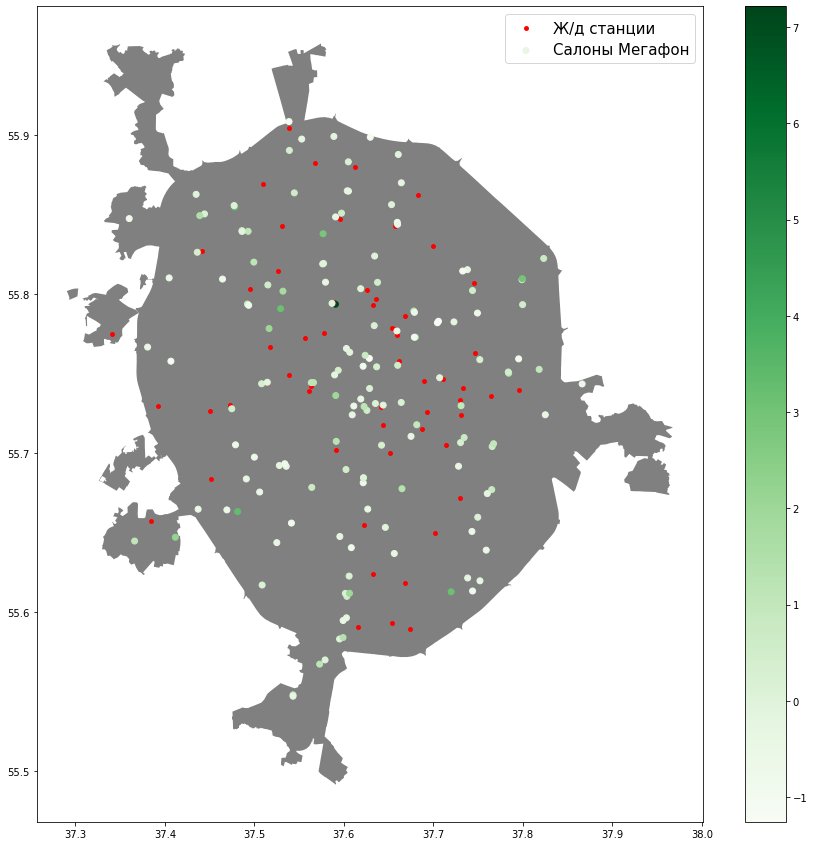

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
gdf[gdf.id == 2555133].plot(ax=ax, color='grey')

# subway_gdf[subway_gdf.id == 2555133].plot(ax=ax, label='Станции метро', color='r', markersize=15)
stations_gdf[stations_gdf.id == 2555133].plot(ax=ax, label='Ж/д станции', color='r', markersize=15)

train[train.id == 2555133].plot(column='target', cmap='Greens', ax=ax, legend=True, label='Салоны Мегафон')

plt.legend(fontsize=15)

#### folium

In [ ]:
m = folium.Map(location=[55.75370903771494, 37.61981338262558],
               tiles='cartodbpositron')

colormap = cm.LinearColormap(colors=['white','green'],
                             vmin=train.target.min(),
                             vmax=train.target.max())
colormap.caption = 'target'

stores_layer = folium.FeatureGroup(name='Салоны Мегафон')
stations_layer = folium.FeatureGroup(name='Ж/д станции')
subway_layer = folium.FeatureGroup(name='Станции метро')

for _, row in train[train.id == 2555133].iterrows():
  info = '''
  target: {}\n
  shortest_dist: {}\n
  subway: {}\n
  retail: {}
  '''.format(round(row.target, 3),
             round(row.shortest_dist, 3),
             round(row.subway, 3),
             row.is_retail)
  folium.CircleMarker(location=(row.lat, row.lon), 
                      radius=6,
                      weight=1,
                      color = 'green',
                      fill_color=colormap(row.target),
                      fill_opacity = 1,
                      popup=info).add_to(stores_layer)

for point in stations[2555133]:
  folium.CircleMarker(location=[point.y, point.x],
                      radius=3,
                      color = 'gray',
                      fill_color='gray',
                      fill_opacity = 1).add_to(stations_layer)

for point in subway[2555133]:
  folium.CircleMarker(location=[point.y, point.x],
                      radius=4,
                      stroke=False,
                      color = 'red',
                      fill_color='red',
                      fill_opacity = .6).add_to(subway_layer)

folium.GeoJson(unary_union(retail[2555133]), name='Торговые центры').add_to(m)

m.add_child(colormap)
m.add_child(stations_layer)
m.add_child(subway_layer)
m.add_child(stores_layer)
m.add_child(folium.map.LayerControl('topleft', collapsed=False))

m

### Fit model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop(['point_id', 'geometry', 'city', 'id'], axis=1), y_train)

In [ ]:
mean_absolute_error(y_valid, model.predict(X_valid.drop(['point_id', 'geometry', 'city', 'id'], axis=1)))

0.6700277099634622

### Make submission

In [ ]:
# Здесь одна точка не попала в границы из OSM
test = find_city(test).append(test[test.point_id == 'h3S4qdms'])
test.city.iloc[-1], test.id.iloc[-1] = 'Санкт-Петербург',	421007

In [ ]:
test = find_stations(test)
test = find_retail(test)
test = find_subway(test)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(test.sort_index().drop(['point_id', 'geometry', 'city', 'id', 'target'], axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)